Author: Yann Charbon <yann.charbon@heig-vd.ch>

In [1]:
from DAGDatasetGenerator import DAGDatasetGenerator
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

generator = DAGDatasetGenerator()

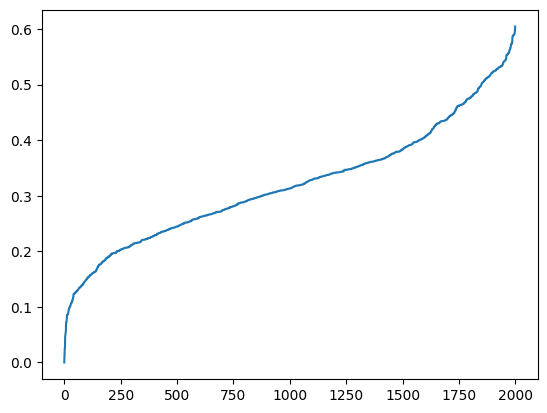

In [ ]:
dags, perfs, adj_matrix = generator.run_once_double_flux(22, keep_dags_count=500, keep_random_dags=True, max_steps=2500)

perfs = np.asarray(perfs)
perfs = 1 - perfs / np.max(perfs)
dags = np.asarray(dags)
sorted_indices = np.argsort(perfs)
perfs_sorted = perfs[sorted_indices]
dags_sorted = dags[sorted_indices]

fig = plt.figure()
plt.plot(perfs_sorted)
plt.show()

In [2]:
def compute_empirical_perf(G: nx.DiGraph, adj_matrix):
    def get_nodes_at_rank(G: nx.DiGraph, rank: int):
        # Compute shortest path lengths from the source
        path_lengths = nx.single_source_shortest_path_length(G, 0)
        return [node for node, length in path_lengths.items() if length == rank]

    def get_max_rank(G: nx.DiGraph):
        path_lengths = nx.single_source_shortest_path_length(G, 0)
        return max(path_lengths.values())

    def compute_weighted_branching_factor(G: nx.DiGraph):
        score = 0
        rank = 0
        nodes_at_rank = get_nodes_at_rank(G, rank)
        while nodes_at_rank:
            for node in nodes_at_rank:
                children_count = len(list(G.successors(node)))
                if children_count > 1:
                    score += children_count
            rank += 1
            nodes_at_rank = get_nodes_at_rank(G, rank)
        return score

    def compute_global_branching_performance(G: nx.DiGraph, adj_matrix):
        global_branching_perf = 0
        for node in range(len(G.nodes)):
            branching_perf = 1
            children = list(G.successors(node))
            if not children:
                continue
            for child in children:
                branching_perf *= adj_matrix[node][child]
            if node > 0:
                parent = list(G.predecessors(node))[0]
                branching_perf *= adj_matrix[parent][node]
            global_branching_perf += branching_perf
        return global_branching_perf

    def compute_perf_for_one_node(node, G: nx.DiGraph, adj_matrix):
        rank = nx.shortest_path_length(G, target=node, source=0)
        done = False
        parent = 0
        child = node
        link_to_root_quality = 1.0
        cumulated_link_to_root_children_count = 0
        while not done:
            parent = list(G.predecessors(child))[0]
            if parent == 0:
                done = True
                break
            link_to_root_quality *= adj_matrix[parent][child]
            cumulated_link_to_root_children_count += len(list(G.successors(child)))
            child = parent
        children_count = len(list(G.successors(node)))
        return cumulated_link_to_root_children_count, children_count, rank, link_to_root_quality

    total_nodes_count = len(G.nodes)

    path_sum_list = []
    global_children_count = 0
    global_rank = 0
    global_link_to_root_quality = 0

    for node in range(1, len(G.nodes)):
        cumulated_link_to_root_children_count, children_count, rank, link_to_root_quality = compute_perf_for_one_node(node, G, adj_matrix)
        path_sum_list.append(cumulated_link_to_root_children_count)
        global_children_count += children_count
        global_rank += rank
        global_link_to_root_quality += link_to_root_quality

    # Normalize
    global_children_count_ratio = global_children_count / total_nodes_count

    # Ensure cumulated link-to-root children count ratio stays in [0,1]
    if len(path_sum_list) == 0:
        global_cumulated_link_to_root_children_count_ratio = 0
    else:
        max_path_sum = max(path_sum_list)
        if max_path_sum == 0:
            global_cumulated_link_to_root_children_count_ratio = 0
        else:
            total_path_sum = sum(path_sum_list)
            global_cumulated_link_to_root_children_count_ratio = total_path_sum / (len(path_sum_list) * max_path_sum)

    max_rank = get_max_rank(G)
    max_possible_rank_sum = total_nodes_count * max_rank
    global_rank_ratio = global_rank / max_possible_rank_sum if max_possible_rank_sum > 0 else 0
    global_link_to_root_quality_ratio = global_link_to_root_quality / total_nodes_count

    global_branching_factor_ratio = compute_weighted_branching_factor(G) / total_nodes_count
    global_max_rank_ratio = get_max_rank(G) / total_nodes_count
    global_branching_perf_ratio = compute_global_branching_performance(G, adj_matrix) / total_nodes_count

    return (
        global_children_count_ratio,
        global_cumulated_link_to_root_children_count_ratio,
        global_rank_ratio,
        global_link_to_root_quality_ratio,
        global_branching_factor_ratio,
        global_max_rank_ratio,
        global_branching_perf_ratio
    )

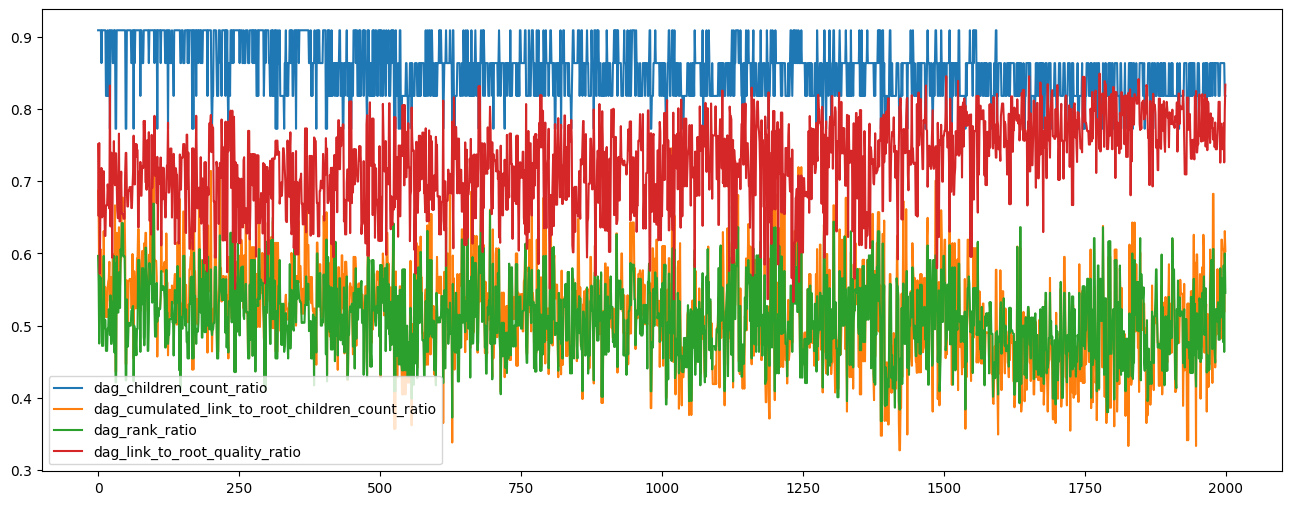

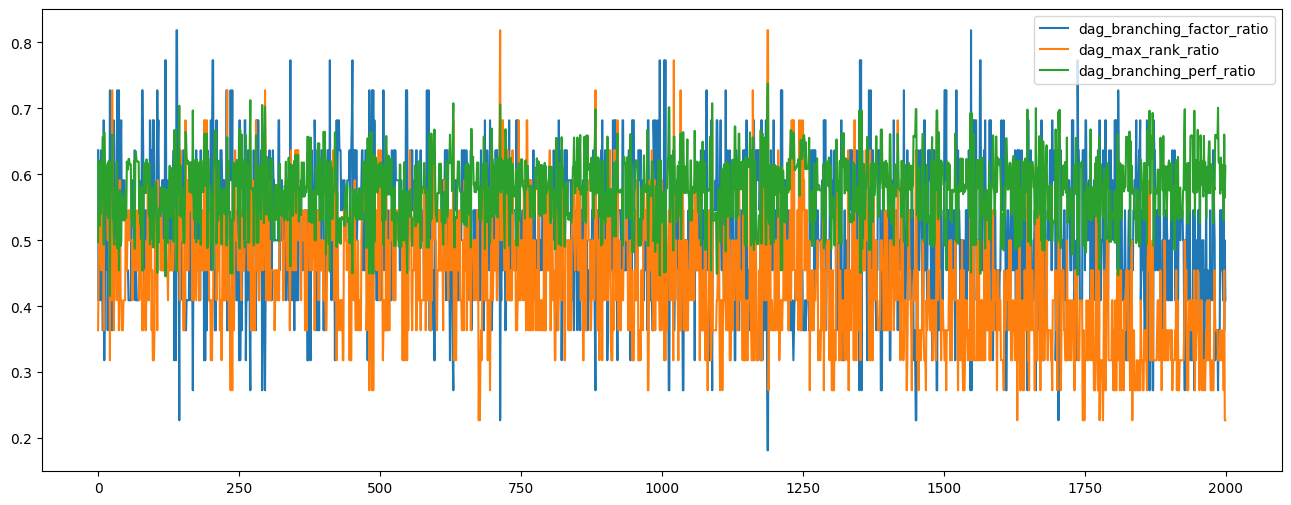

In [3]:
dag_children_count_ratio = []
dag_cumulated_link_to_root_children_count_ratio = []
dag_rank_ratio = []
dag_link_to_root_quality_ratio = []
dag_branching_factor_ratio = []
dag_max_rank_ratio = []
dag_branching_perf_ratio = []

for dag in dags:
    G = nx.DiGraph()
    G.add_edges_from(dag)

    (
        children_count_ratio,
        cumulated_link_to_root_children_count_ratio,
        rank_ratio,
        link_to_root_quality_ratio,
        branching_factor_ratio,
        max_rank_ratio,
        branching_perf_ratio
    ) = compute_empirical_perf(G, adj_matrix)

    # Append to lists
    dag_children_count_ratio.append(children_count_ratio)
    dag_cumulated_link_to_root_children_count_ratio.append(cumulated_link_to_root_children_count_ratio)
    dag_rank_ratio.append(rank_ratio)
    dag_link_to_root_quality_ratio.append(link_to_root_quality_ratio)
    dag_branching_factor_ratio.append(branching_factor_ratio)
    dag_max_rank_ratio.append(max_rank_ratio)
    dag_branching_perf_ratio.append(branching_perf_ratio)

# Convert lists to NumPy arrays
dag_children_count_ratio = np.array(dag_children_count_ratio)
dag_cumulated_link_to_root_children_count_ratio = np.array(dag_cumulated_link_to_root_children_count_ratio)
dag_rank_ratio = np.array(dag_rank_ratio)
dag_link_to_root_quality_ratio = np.array(dag_link_to_root_quality_ratio)
dag_branching_factor_ratio = np.array(dag_branching_factor_ratio)
dag_max_rank_ratio = np.array(dag_max_rank_ratio)
dag_branching_perf_ratio = np.array(dag_branching_perf_ratio)

# Apply sorted indices
dag_children_count_ratio = dag_children_count_ratio[sorted_indices]
dag_cumulated_link_to_root_children_count_ratio = dag_cumulated_link_to_root_children_count_ratio[sorted_indices]
dag_rank_ratio = dag_rank_ratio[sorted_indices]
dag_link_to_root_quality_ratio = dag_link_to_root_quality_ratio[sorted_indices]
dag_branching_factor_ratio = dag_branching_factor_ratio[sorted_indices]
dag_max_rank_ratio = dag_max_rank_ratio[sorted_indices]
dag_branching_perf_ratio = dag_branching_perf_ratio[sorted_indices]


plt.figure(figsize=(16, 6))
plt.plot(dag_children_count_ratio, label="dag_children_count_ratio")
plt.plot(dag_cumulated_link_to_root_children_count_ratio, label="dag_cumulated_link_to_root_children_count_ratio")
plt.plot(dag_rank_ratio, label="dag_rank_ratio")
plt.plot(dag_link_to_root_quality_ratio, label="dag_link_to_root_quality_ratio")
plt.legend()
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(dag_branching_factor_ratio, label="dag_branching_factor_ratio")
plt.plot(dag_max_rank_ratio, label="dag_max_rank_ratio")
plt.plot(dag_branching_perf_ratio, label="dag_branching_perf_ratio")
plt.legend()
plt.show()


In [3]:
# construct dataset

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import optuna
import joblib

/home/yann/miniconda3/envs/dag-gen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
dag_children_count_ratio = []
dag_cumulated_link_to_root_children_count_ratio = []
dag_rank_ratio = []
dag_link_to_root_quality_ratio = []
dag_branching_factor_ratio = []
dag_max_rank_ratio = []
dag_branching_perf_ratio = []

all_perfs = []

for i in range(0, 100):
    dags, perfs, adj_matrix = generator.run_once_double_flux(22, keep_dags_count=500, keep_random_dags=True, max_steps=2500)
    perfs = 1 - perfs / np.max(perfs)   # normalize between 0 (worst) and 1 (best)
    for perf in perfs:
        all_perfs.append(perf)

    for dag in dags:
        G = nx.DiGraph()
        G.add_edges_from(dag)

        (
            children_count_ratio,
            cumulated_link_to_root_children_count_ratio,
            rank_ratio,
            link_to_root_quality_ratio,
            branching_factor_ratio,
            max_rank_ratio,
            branching_perf_ratio
        ) = compute_empirical_perf(G, adj_matrix)

        # Append to lists
        dag_children_count_ratio.append(children_count_ratio)
        dag_cumulated_link_to_root_children_count_ratio.append(cumulated_link_to_root_children_count_ratio)
        dag_rank_ratio.append(rank_ratio)
        dag_link_to_root_quality_ratio.append(link_to_root_quality_ratio)
        dag_branching_factor_ratio.append(branching_factor_ratio)
        dag_max_rank_ratio.append(max_rank_ratio)
        dag_branching_perf_ratio.append(branching_perf_ratio)

    print(f"Generated for topology {i}")

# Convert lists to NumPy arrays
dag_children_count_ratio = np.array(dag_children_count_ratio)
dag_cumulated_link_to_root_children_count_ratio = np.array(dag_cumulated_link_to_root_children_count_ratio)
dag_rank_ratio = np.array(dag_rank_ratio)
dag_link_to_root_quality_ratio = np.array(dag_link_to_root_quality_ratio)
dag_branching_factor_ratio = np.array(dag_branching_factor_ratio)
dag_max_rank_ratio = np.array(dag_max_rank_ratio)
dag_branching_perf_ratio = np.array(dag_branching_perf_ratio)

all_perfs = np.array(all_perfs)

Generated for topology 0
Generated for topology 1
Generated for topology 2
Generated for topology 3
Generated for topology 4
Generated for topology 5
Generated for topology 6
Generated for topology 7
Generated for topology 8
Generated for topology 9
Generated for topology 10
Generated for topology 11
Generated for topology 12
Generated for topology 13
Generated for topology 14
Generated for topology 15
Generated for topology 16
Generated for topology 17
Generated for topology 18
Generated for topology 19
Generated for topology 20
Generated for topology 21
Generated for topology 22
Generated for topology 23
Generated for topology 24
Generated for topology 25
Generated for topology 26
Generated for topology 27
Generated for topology 28
Generated for topology 29
Generated for topology 30
Generated for topology 31
Generated for topology 32
Generated for topology 33
Generated for topology 34
Generated for topology 35
Generated for topology 36
Generated for topology 37
Generated for topology

In [26]:
n_samples = len(all_perfs)
n_features = 7

print(len(dag_children_count_ratio))
print(f"n_samples = {n_samples}, n_features = {n_features}")

X = np.zeros((n_samples, n_features))
y = np.zeros((n_samples,))


for n in range(0, n_samples):
    X[n] = [dag_children_count_ratio[n], dag_cumulated_link_to_root_children_count_ratio[n], dag_rank_ratio[n], dag_link_to_root_quality_ratio[n], dag_branching_factor_ratio[n], dag_max_rank_ratio[n], dag_branching_perf_ratio[n]]
    y[n] = all_perfs[n]

joblib.dump(X, "X_empirical.dump")
joblib.dump(y, "y_empirical.dump")

50000
n_samples = 50000, n_features = 7


['y_empirical.dump']

In [27]:
X = joblib.load("X_empirical.dump")
y = joblib.load("y_empirical.dump")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

regr = MLPRegressor(hidden_layer_sizes=(2048, 1024, 512, 256), random_state=42, max_iter=100000, tol=0.0000001, learning_rate_init=0.0001, verbose=True)

regr.fit(X_train, y_train)
regr.score(X_test, y_test)

Iteration 1, loss = 0.00760286
Iteration 2, loss = 0.00477009
Iteration 3, loss = 0.00417361
Iteration 4, loss = 0.00390306
Iteration 5, loss = 0.00374485
Iteration 6, loss = 0.00352728
Iteration 7, loss = 0.00340750
Iteration 8, loss = 0.00332977
Iteration 9, loss = 0.00327019
Iteration 10, loss = 0.00322792
Iteration 11, loss = 0.00313811
Iteration 12, loss = 0.00322934
Iteration 13, loss = 0.00316237
Iteration 14, loss = 0.00313357
Iteration 15, loss = 0.00309152
Iteration 16, loss = 0.00309313
Iteration 17, loss = 0.00313653
Iteration 18, loss = 0.00312129
Iteration 19, loss = 0.00310082
Iteration 20, loss = 0.00304644
Iteration 21, loss = 0.00309031
Iteration 22, loss = 0.00306227
Iteration 23, loss = 0.00305755
Iteration 24, loss = 0.00303069
Iteration 25, loss = 0.00307997
Iteration 26, loss = 0.00302462
Iteration 27, loss = 0.00302961
Iteration 28, loss = 0.00300895
Iteration 29, loss = 0.00303849
Iteration 30, loss = 0.00304694
Iteration 31, loss = 0.00300567
Iteration 32, los

0.6469963743173232

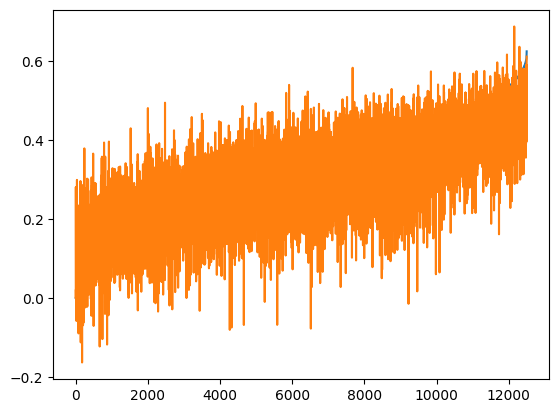

In [29]:
y_pred = regr.predict(X_test)

y_sorted_indices = np.argsort(y_test)

plt.figure()
plt.plot(y_test[y_sorted_indices])
plt.plot(y_pred[y_sorted_indices])
plt.show()

In [ ]:
# Objective function for Optuna
def objective(trial):
    # Suggest number of hidden layers (1-4 layers)
    #n_layers = trial.suggest_int("n_layers", 1, 3)

    # Suggest number of nodes per layer (50-500 nodes)
    #hidden_layer_sizes = tuple(
    #    trial.suggest_int(f"n_units_l{i}", 50, 500) for i in range(n_layers)
    #)

    # Suggest activation function
    #activation = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])

    # Suggest learning rate initialization
    #learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-2, log=True)

    solver = trial.suggest_categorical("solver", ["adam", "lbfgs", "sgd"])
    learning_rate_method = trial.suggest_categorical("learning_rate", ["adaptive", "constant", "invscaling"])

    #print(f"Starting trial with hidden_layer_size = {hidden_layer_sizes}, activation = {activation}, learning_rate_init = {learning_rate_init}")

    # Create the model
    model = MLPRegressor(
        hidden_layer_sizes=(2048, 1024, 512, 256),
        activation="relu",
        solver=solver,
        learning_rate=learning_rate_method,
        max_iter=5000,
        tol=0.0000001,
        random_state=42,
        learning_rate_init=0.0001,
        verbose=True
    )

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict and calculate F1 score
    #y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)

    #print(f"Finished trial: F1 = {score} with hidden_layer_size = {hidden_layer_sizes}, activation = {activation}, learning_rate_init = {learning_rate_init}")

    return score

# Create a study and optimize
study = optuna.create_study(direction="maximize", storage="sqlite:///optuna_empirical.db", study_name="MLP Regressor (2048, 1024, 512, 256) solver+learning_rate_method optimization", load_if_exists=True)
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and their corresponding F1 score
print("Best trial:")
print(f"Score: {study.best_value}")
print("Best Hyperparameters:", study.best_params)

0.707994022419185


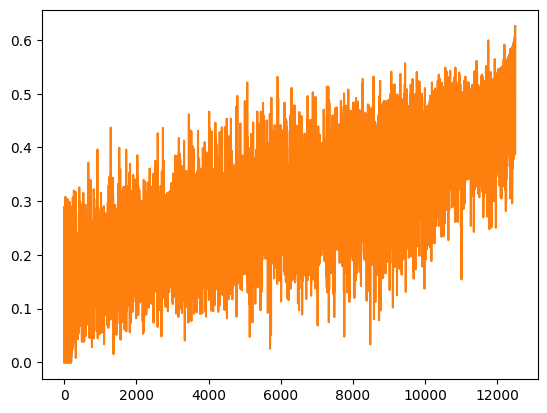

In [36]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=5000, learning_rate=0.01, max_depth=20)
xgb_model.fit(X_train, y_train)
print(xgb_model.score(X_test, y_test))

y_pred = xgb_model.predict(X_test)

y_sorted_indices = np.argsort(y_test)

plt.figure()
plt.plot(y_test[y_sorted_indices])
plt.plot(y_pred[y_sorted_indices])
plt.show()

In [39]:
# Objective function for Optuna
def objective(trial):
    # Suggest number of hidden layers (1-4 layers)
    #n_layers = trial.suggest_int("n_layers", 1, 3)

    # Suggest number of nodes per layer (50-500 nodes)
    #hidden_layer_sizes = tuple(
    #    trial.suggest_int(f"n_units_l{i}", 50, 500) for i in range(n_layers)
    #)

    # Suggest activation function
    #activation = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])

    # Suggest learning rate initialization
    #learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-2, log=True)

    #solver = trial.suggest_categorical("solver", ["adam", "lbfgs", "sgd"])
    #learning_rate_method = trial.suggest_categorical("learning_rate", ["adaptive", "constant", "invscaling"])

    #print(f"Starting trial with hidden_layer_size = {hidden_layer_sizes}, activation = {activation}, learning_rate_init = {learning_rate_init}")

    n_estimators = trial.suggest_int("n_estimators", 500, 30000)
    learning_rate = trial.suggest_float("learning_rate_init", 0.00001, 0.1, log=True)
    n_estimators = trial.suggest_int("max_depth", 4, 30)

    # Create the model
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=n_estimators)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict and calculate F1 score
    #y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)

    #print(f"Finished trial: F1 = {score} with hidden_layer_size = {hidden_layer_sizes}, activation = {activation}, learning_rate_init = {learning_rate_init}")

    return score

# Create a study and optimize
study = optuna.create_study(direction="maximize", storage="sqlite:///optuna_empirical.db", study_name="XGBRegressor1", load_if_exists=True)
study.optimize(objective, n_trials=500)

# Print the best hyperparameters and their corresponding F1 score
print("Best trial:")
print(f"Score: {study.best_value}")
print("Best Hyperparameters:", study.best_params)

[I 2025-03-20 22:39:57,940] A new study created in RDB with name: XGBRegressor1
[I 2025-03-20 22:39:58,126] Trial 0 finished with value: 0.01658185005255719 and parameters: {'n_estimators': 24620, 'learning_rate_init': 0.0017012144650942894, 'max_depth': 8}. Best is trial 0 with value: 0.01658185005255719.
[I 2025-03-20 22:39:59,851] Trial 1 finished with value: 0.27280148854528585 and parameters: {'n_estimators': 6890, 'learning_rate_init': 0.01452227322383302, 'max_depth': 18}. Best is trial 1 with value: 0.27280148854528585.
[I 2025-03-20 22:40:00,052] Trial 2 finished with value: 0.00011419402458368033 and parameters: {'n_estimators': 7582, 'learning_rate_init': 1.3290472907230197e-05, 'max_depth': 10}. Best is trial 1 with value: 0.27280148854528585.
[I 2025-03-20 22:40:00,215] Trial 3 finished with value: 0.47464701051538216 and parameters: {'n_estimators': 27419, 'learning_rate_init': 0.09869489698731086, 'max_depth': 7}. Best is trial 3 with value: 0.47464701051538216.
[I 2025-

KeyboardInterrupt: 